<table align="center">
  <td align="center"><a target="_blank" href="http://introtodeeplearning.com">
        <img src="http://introtodeeplearning.com/images/colab/mit.png" style="padding-bottom:5px;" />
      Visit MIT Deep Learning</a></td>
  <td align="center"><a target="_blank" href="https://colab.research.google.com/github/aamini/introtodeeplearning/blob/master/lab3/RL.ipynb">
        <img src="http://introtodeeplearning.com/images/colab/colab.png?v2.0"  style="padding-bottom:5px;" />Run in Google Colab</a></td>
  <td align="center"><a target="_blank" href="https://github.com/aamini/introtodeeplearning/blob/master/lab3/RL.ipynb">
        <img src="http://introtodeeplearning.com/images/colab/github.png"  height="70px" style="padding-bottom:5px;"  />View Source on GitHub</a></td>
</table>

# Copyright Information

In [1]:
# Copyright 2020 MIT 6.S191 Introduction to Deep Learning. All Rights Reserved.
# 
# Licensed under the MIT License. You may not use this file except in compliance
# with the License. Use and/or modification of this code outside of 6.S191 must
# reference:
#
# © MIT 6.S191: Introduction to Deep Learning
# http://introtodeeplearning.com
#

# Laboratory 3: Reinforcement Learning

Reinforcement learning (RL) is a subset of machine learning which poses learning problems as interactions between agents and environments. It often assumes agents have no prior knowledge of a world, so they must learn to navigate environments by optimizing a reward function. Within an environment, an agent can take certain actions and receive feedback, in the form of positive or negative rewards, with respect to their decision. As such, an agent's feedback loop is somewhat akin to the idea of "trial and error", or the manner in which a child might learn to distinguish between "good" and "bad" actions.

In practical terms, our RL agent will interact with the environment by taking an action at each timestep, receiving a corresponding reward, and updating its state according to what it has "learned".  

![alt text](https://www.kdnuggets.com/images/reinforcement-learning-fig1-700.jpg)

While the ultimate goal of reinforcement learning is to teach agents to act in the real, physical world, games provide a convenient proving ground for developing RL algorithms and agents. Games have some properties that make them particularly well suited for RL: 

1.   In many cases, games have perfectly describable environments. For example, all rules of chess can be formally written and programmed into a chess game simulator;
2.   Games are massively parallelizable. Since they do not require running in the real world, simultaneous environments can be run on large data clusters; 
3.   Simpler scenarios in games enable fast prototyping. This speeds up the development of algorithms that could eventually run in the real-world; and
4.   ... Games are fun! 

In previous labs, we have explored both supervised (with LSTMs, CNNs) and unsupervised / semi-supervised (with VAEs) learning tasks. Reinforcement learning is fundamentally different, in that we are training a deep learning algorithm to govern the actions of our RL agent, that is trying, within its environment, to find the optimal way to achieve a goal. The goal of training an RL agent is to determine the best next step to take to earn the greatest final payoff or return. In this lab, we focus on building a reinforcement learning algorithm to master two different environments with varying complexity. 

1.   **Cartpole**:   Balance a pole, protruding from a cart, in an upright position by only moving the base left or right. Environment with a low-dimensional observation space.
2.   [**Pong**](https://en.wikipedia.org/wiki/Pong): Beat your competitors (whether other AI or humans!) at the game of Pong. Environment with a high-dimensional observation space -- learning directly from raw pixels.

Let's get started! First we'll import TensorFlow, the course package, and some dependencies.


In [2]:
!apt-get install -y xvfb python-opengl x11-utils > /dev/null 2>&1
!pip install gym pyvirtualdisplay scikit-video > /dev/null 2>&1

%tensorflow_version 2.x
import tensorflow as tf

import numpy as np
import base64, io, time, gym
import IPython, functools
import matplotlib.pyplot as plt
from tqdm import tqdm

!pip install mitdeeplearning
import mitdeeplearning as mdl

Before we dive in, let's take a step back and outline our approach, which is generally applicable to reinforcement learning problems in general:

1. **Initialize our environment and our agent**: here we will describe the different observations and actions the agent can make in the environment.
2. **Define our agent's memory**: this will enable the agent to remember its past actions, observations, and rewards.
3. **Define a reward function**: describes the reward associated with an action or sequence of actions.
4. **Define the learning algorithm**: this will be used to reinforce the agent's good behaviors and discourage bad behaviors.


# Part 1: Cartpole

## 3.1 Define the Cartpole environment and agent

### Environment 

In order to model the environment for both the Cartpole and Pong tasks, we'll be using a toolkit developed by OpenAI called [OpenAI Gym](https://gym.openai.com/). It provides several pre-defined environments for training and testing reinforcement learning agents, including those for classic physics control tasks, Atari video games, and robotic simulations. To access the Cartpole environment, we can use `env = gym.make("CartPole-v0")`, which we gained access to when we imported the `gym` package. We can instantiate different [environments](https://gym.openai.com/envs/#classic_control) by passing the enivronment name to the `make` function.

One issue we might experience when developing RL algorithms is that many aspects of the learning process are inherently random: initializing game states, changes in the environment, and the agent's actions. As such, it can be helpful to set a initial "seed" for the environment to ensure some level of reproducibility. Much like you might use `numpy.random.seed`, we can call the comparable function in gym, `seed`, with our defined environment to ensure the environment's random variables are initialized the same each time.

In [3]:
### Instantiate the Cartpole environment ###

env = gym.make("CartPole-v0")
env.seed(1)

[1]

In Cartpole, a pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pole starts upright, and the goal is to prevent it from falling over. The system is controlled by applying a force of +1 or -1 to the cart. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center of the track. A visual summary of the cartpole environment is depicted below:

<img width="400px" src="https://danielpiedrahita.files.wordpress.com/2017/02/cart-pole.png"></img>

Given this setup for the environment and the objective of the game, we can think about: 1) what observations help define the environment's state; 2) what actions the agent can take. 

First, let's consider the observation space. In this Cartpole environment our observations are:

1. Cart position
2. Cart velocity
3. Pole angle
4. Pole rotation rate

We can confirm the size of the space by querying the environment's observation space:


In [4]:
n_observations = env.observation_space
print("Environment has observation space =", n_observations)

Environment has observation space = Box(4,)


Second, we consider the action space. At every time step, the agent can move either right or left. Again we can confirm the size of the action space by querying the environment:

In [5]:
n_actions = env.action_space.n
print("Number of possible actions that the agent can choose from =", n_actions)

Number of possible actions that the agent can choose from = 2


### Cartpole agent

Now that we have instantiated the environment and understood the dimensionality of the observation and action spaces, we are ready to define our agent. In deep reinforcement learning, a deep neural network defines the agent. This network will take as input an observation of the environment and output the probability of taking each of the possible actions. Since Cartpole is defined by a low-dimensional observation space, a simple feed-forward neural network should work well for our agent. We will define this using the `Sequential` API.


In [6]:
### Define the Cartpole agent ###

# Defines a feed-forward neural network
def create_cartpole_model():
  model = tf.keras.models.Sequential([
      # First Dense layer
      tf.keras.layers.Dense(units=32, activation='relu'),

      # TODO: Define the last Dense layer, which will provide the network's output.
      # Think about the space the agent needs to act in!
      # '''TODO: Dense layer to output action probabilities'''
      tf.keras.layers.Dense(n_actions, activation='softmax')
  ])
  return model

cartpole_model = create_cartpole_model()

Now that we have defined the core network architecture, we will define an *action function* that executes a forward pass through the network, given a set of observations, and samples from the output. This sampling from the output probabilities will be used to select the next action for the agent. 

**Critically, this action function is totally general -- we will use this function for both Cartpole and Pong, and it is applicable to other RL tasks, as well!**

In [7]:
### Define the agent's action function ###

# Function that takes observations as input, executes a forward pass through model, 
#   and outputs a sampled action.
# Arguments:
#   model: the network that defines our agent
#   observation: observation which is fed as input to the model
# Returns:
#   action: choice of agent action
def choose_action(model, observation):
  # add batch dimension to the observation
  observation = np.expand_dims(observation, axis=0)

  '''TODO: feed the observations through the model to predict the log probabilities of each possible action.'''
  logits = model.predict(observation)
  
  # pass the log probabilities through a softmax to compute true probabilities
  prob_weights = logits
  
  '''TODO: randomly sample from the prob_weights to pick an action.
  Hint: carefully consider the dimensionality of the input probabilities (vector) and the output action (scalar)'''
  action = np.random.choice(n_actions, size=1, p=prob_weights.flatten())[0]

  return action

## 3.2 Define the agent's memory

Now that we have instantiated the environment and defined the agent network architecture and action function, we are ready to move on to the next step in our RL workflow:
1. **Initialize our environment and our agent**: here we will describe the different observations and actions the agent can make in the environment.
2. **Define our agent's memory**: this will enable the agent to remember its past actions, observations, and rewards.
3. **Define the learning algorithm**: this will be used to reinforce the agent's good behaviors and discourage bad behaviors.

In reinforcement learning, training occurs alongside the agent's acting in the environment; an *episode* refers to a sequence of actions that ends in some terminal state, such as the pole falling down or the cart crashing. The agent will need to remember all of its observations and actions, such that once an episode ends, it can learn to "reinforce" the good actions and punish the undesirable actions via training. Our first step is to define a simple memory buffer that contains the agent's observations, actions, and received rewards from a given episode. 

**Once again, note the modularity of this memory buffer -- it can and will be applied to other RL tasks as well!**

In [8]:
### Agent Memory ###

class Memory:
  def __init__(self): 
      self.clear()

  # Resets/restarts the memory buffer
  def clear(self): 
      self.observations = []
      self.actions = []
      self.rewards = []

  # Add observations, actions, rewards to memory
  def add_to_memory(self, new_observation, new_action, new_reward): 
      self.observations.append(new_observation)
      '''TODO: update the list of actions with new action'''
      self.actions.append(new_action)
      '''TODO: update the list of rewards with new reward'''
      self.rewards.append(new_reward)
        
memory = Memory()

## 3.3 Reward function

We're almost ready to begin the learning algorithm for our agent! The next step is to compute the rewards of our agent as it acts in the environment. Since we (and the agent) is uncertain about if and when the game or task will end (i.e., when the pole will fall), it is useful to emphasize getting rewards **now** rather than later in the future -- this is the idea of discounting. This is a similar concept to discounting money in the case of interest. ecall from lecture, we use reward discount to give more preference at getting rewards now rather than later in the future. The idea of discounting rewards is similar to discounting money in the case of interest.

To compute the expected cumulative reward, known as the **return**, at a given timestep in a learning episode, we sum the discounted rewards expected at that time step $t$, within a learning episode, and projecting into the future. We define the return (cumulative reward) at a time step $t$, $R_{t}$ as:

>$R_{t}=\sum_{k=0}^\infty\gamma^kr_{t+k}$

where  $0 < \gamma < 1$ is the discount factor and $r_{t}$ is the reward at time step $t$, and the index $k$ increments projection into the future within a single learning episode. Intuitively, you can think of this function as depreciating any rewards received at later time steps, which will force the agent prioritize getting rewards now. Since we can't extend episodes to infinity, in practice the computation will be limited to the number of timesteps in an episode -- after that the reward is assumed to be zero.

Take note of the form of this sum -- we'll have to be clever about how we implement this function. Specifically, we'll need to initialize an array of zeros, with length of the number of time steps, and fill it with the real discounted reward values as we loop through the rewards from the episode, which will have been saved in the agents memory. What we ultimately care about is which actions are better relative to other actions taken in that episode -- so, we'll normalize our computed rewards, using the mean and standard deviation of the rewards across the learning episode.


In [9]:
### Reward function ###

# Helper function that normalizes an np.array x
def normalize(x):
  x -= np.mean(x)
  x /= np.std(x)
  return x.astype(np.float32)

# Compute normalized, discounted, cumulative rewards (i.e., return)
# Arguments:
#   rewards: reward at timesteps in episode
#   gamma: discounting factor
# Returns:
#   normalized discounted reward
def discount_rewards(rewards, gamma=0.95): 
  discounted_rewards = np.zeros_like(rewards)
  R = 0
  for t in reversed(range(0, len(rewards))):
      # update the total discounted reward
      R = R * gamma + rewards[t]
      discounted_rewards[t] = R
      
  return normalize(discounted_rewards)

## 3.4 Learning algorithm

Now we can start to define the learing algorithm which will be used to reinforce good behaviors of the agent and discourage bad behaviours. In this lab, we will focus on *policy gradient* methods which aim to **maximize** the likelihood of actions that result in large rewards. Equivalently, this means that we want to **minimize** the negative likelihood of these same actions. We achieve this by simply **scaling** the probabilities by their associated rewards -- effectively amplifying the likelihood of actions that result in large rewards.

Since the log function is monotonically increasing, this means that minimizing **negative likelihood** is equivalent to minimizing **negative log-likelihood**.  Recall that we can easily compute the negative log-likelihood of a discrete action by evaluting its [softmax cross entropy](https://www.tensorflow.org/api_docs/python/tf/nn/sparse_softmax_cross_entropy_with_logits). Like in supervised learning, we can use stochastic gradient descent methods to achieve the desired minimization. 

Let's begin by defining the loss function.

In [10]:
### Loss function ###

# Arguments:
#   logits: network's predictions for actions to take
#   actions: the actions the agent took in an episode
#   rewards: the rewards the agent received in an episode
# Returns:
#   loss
def compute_loss(logits, actions, rewards): 
  '''TODO: complete the function call to compute the negative log probabilities'''
  neg_logprob = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=actions)
  
  '''TODO: scale the negative log probability by the rewards'''
  loss = tf.reduce_mean(neg_logprob*rewards)
  return loss

Now let's use the loss function to define a training step of our learning algorithm:

In [11]:
### Training step (forward and backpropagation) ###

def train_step(model, optimizer, observations, actions, discounted_rewards):
  with tf.GradientTape() as tape:
      # Forward propagate through the agent network
      logits = model(observations)

      '''TODO: call the compute_loss function to compute the loss'''
      loss = compute_loss(logits, actions, discounted_rewards)

  '''TODO: run backpropagation to minimize the loss using the tape.gradient method.
      Use `model.trainable_variables`'''
  grads = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(grads, model.trainable_variables))


## 3.5 Run cartpole!

Having had no prior knowledge of the environment, the agent will begin to learn how to balance the pole on the cart based only on the feedback received from the environment! Having defined how our agent can move, how it takes in new observations, and how it updates its state, we'll see how it gradually learns a policy of actions to optimize balancing the pole as long as possible. To do this, we'll track how the rewards evolve as a function of training -- how should the rewards change as training progresses?

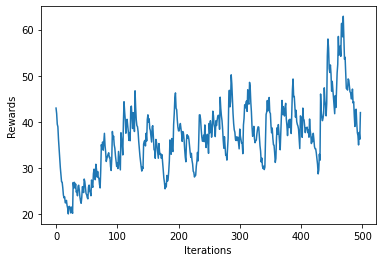

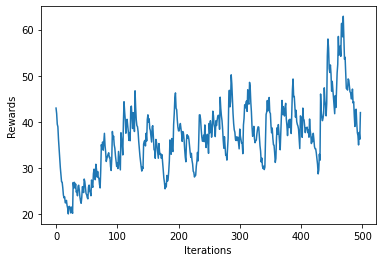

In [12]:
### Cartpole training! ###
with tf.device('/GPU:0'):
  # Learning rate and optimizer
  learning_rate = 1e-3
  optimizer = tf.keras.optimizers.Adam(learning_rate)

  # instantiate cartpole agent
  cartpole_model = create_cartpole_model()

  # to track our progress
  smoothed_reward = mdl.util.LossHistory(smoothing_factor=0.9)
  plotter = mdl.util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Rewards')

  if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists
  for i_episode in range(500):

    plotter.plot(smoothed_reward.get())

    # Restart the environment
    observation = env.reset()
    memory.clear()

    while True:
        # using our observation, choose an action and take it in the environment
        action = choose_action(cartpole_model, observation)
        next_observation, reward, done, info = env.step(action)
        # add to memory
        memory.add_to_memory(observation, action, reward)
        
        # is the episode over? did you crash or do so well that you're done?
        if done:
            # determine total reward and keep a record of this
            total_reward = sum(memory.rewards)
            smoothed_reward.append(total_reward)
            
            # initiate training - remember we don't know anything about how the 
            #   agent is doing until it has crashed!
            train_step(cartpole_model, optimizer, 
                      observations=np.vstack(memory.observations),
                      actions=np.array(memory.actions),
                      discounted_rewards = discount_rewards(memory.rewards))
            
            # reset the memory
            memory.clear()
            break
        # update our observatons
        observation = next_observation

To get a sense of how our agent did, we can save a video of the trained model working on balancing the pole. Realize that this is a brand new environment that the agent has not seen before!

Let's display the saved video to watch how our agent did!


In [13]:
saved_cartpole = mdl.lab3.save_video_of_model(cartpole_model, "CartPole-v0")
mdl.lab3.play_video(saved_cartpole)

Successfully saved 148 frames into CartPole-v0.mp4!


How does the agent perform? Could you train it for shorter amounts of time and still perform well? Do you think that training longer would help even more? 

#Part 2: Pong

In Cartpole, we dealt with an environment that was static -- in other words, it didn't change over time. What happens if our environment is dynamic and unpredictable? Well that's exactly the case in [Pong](https://en.wikipedia.org/wiki/Pong), since part of the environment is the opposing player. We don't know how our opponent will act or react to our actions, so the complexity of our problem increases. It also becomes much more interesting, since we can compete to beat our opponent. RL provides a powerful framework for training AI systems with the ability to handle and interact with dynamic, unpredictable environments. In this part of the lab, we'll use the tools and workflow we explored in Part 1 to build an RL agent capable of playing the game of Pong.


## 3.6 Define and inspect the Pong environment

As with Cartpole, we'll instantiate the Pong environment in the OpenAI gym, using a seed of 1.

In [14]:
env = gym.make("Pong-v0", frameskip=5)
env.seed(1); # for reproducibility

Let's next consider the observation space for the Pong environment. Instead of four physical descriptors of the cart-pole setup, in the case of Pong our observations are the individual video frames (i.e., images) that depict the state of the board. Thus, the observations are 210x160 RGB images (arrays of shape (210,160,3)).

We can again confirm the size of the observation space by query:

In [15]:
print("Environment has observation space =", env.observation_space)

Environment has observation space = Box(210, 160, 3)


In Pong, at every time step, the agent (which controls the paddle) has six actions to choose from: no-op (no operation), move right, move left, fire, fire right, and fire left. Let's confirm the size of the action space by querying the environment:

In [16]:
n_actions = env.action_space.n
print("Number of possible actions that the agent can choose from =", n_actions)

Number of possible actions that the agent can choose from = 6


## 3.7 Define the Pong agent

As before, we'll use a neural network to define our agent. What network architecture do you think would be especially well suited to this game? Since our observations are now in the form of images, we'll add convolutional layers to the network to increase the learning capacity of our network.

In [17]:
### Define the Pong agent ###

# Functionally define layers for convenience
# All convolutional layers will have ReLu activation
Conv2D = functools.partial(tf.keras.layers.Conv2D, padding='same', activation='relu')
Flatten = tf.keras.layers.Flatten
Dense = tf.keras.layers.Dense

# Defines a CNN for the Pong agent
def create_pong_model():
  model = tf.keras.models.Sequential([
    # Convolutional layers
    # First, 16 7x7 filters with 4x4 stride
    Conv2D(filters=16, kernel_size=7, strides=4),

    # TODO: define convolutional layers with 32 5x5 filters and 2x2 stride
    Conv2D(filters=32, kernel_size=5, strides=2),

    # TODO: define convolutional layers with 48 3x3 filters and 2x2 stride
    Conv2D(filters=48, kernel_size=3, strides=2),

    Flatten(),
    
    # Fully connected layer and output
    Dense(units=64, activation='relu'),
    # TODO: define the output dimension of the last Dense layer. 
    # Pay attention to the space the agent needs to act in
    Dense(n_actions, 'softmax')
  
  ])
  return model

pong_model = create_pong_model()

Since we've already defined the action function, `choose_action(model, observation)`, we don't need to define it again. Instead, we'll be able to reuse it later on by passing in our new model we've just created, `pong_model`. This is awesome because our action function provides a modular and generalizable method for all sorts of RL agents!

## 3.8 Pong-specific functions

In Part 1 (Cartpole), we implemented some key functions and classes to build and train our RL agent -- `choose_action(model, observation)` and the `Memory` class, for example. However, in getting ready to apply these to a new game like Pong, we might need to make some slight modifications. 

Namely, we need to think about what happens when a game ends. In Pong, we know a game has ended if the reward is +1 (we won!) or -1 (we lost unfortunately). Otherwise, we expect the reward at a timestep to be zero -- the players (or agents) are just playing eachother. So, after a game ends, we will need to reset the reward to zero when a game ends. This will result in a modified reward function.

In [18]:
### Pong reward function ###

# Compute normalized, discounted rewards for Pong (i.e., return)
# Arguments:
#   rewards: reward at timesteps in episode
#   gamma: discounting factor. Note increase to 0.99 -- rate of depreciation will be slower.
# Returns:
#   normalized discounted reward
def discount_rewards(rewards, gamma=0.99): 
  discounted_rewards = np.zeros_like(rewards)
  R = 0
  for t in reversed(range(0, len(rewards))):
      # NEW: Reset the sum if the reward is not 0 (the game has ended!)
      if rewards[t] != 0:
        R = 0
      # update the total discounted reward as before
      R = R * gamma + rewards[t]
      discounted_rewards[t] = R
      
  return normalize(discounted_rewards)

Additionally, we have to consider the nature of the observations in the Pong environment, and how they will be fed into our network. Our observations in this case are images. Before we input an image into our network, we'll do a bit of pre-processing to crop and scale, clean up the background colors to a single color, and set the important game elements to a single color. Let's use this function to visualize what an observation might look like before and after pre-processing.

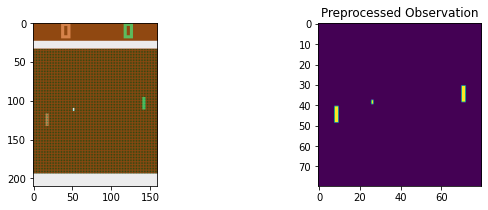

In [19]:
observation = env.reset()
for i in range(30):
  observation, _,_,_ = env.step(0)
observation_pp = mdl.lab3.preprocess_pong(observation)

f = plt.figure(figsize=(10,3))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax.imshow(observation); ax.grid(False);
ax2.imshow(np.squeeze(observation_pp)); ax2.grid(False); plt.title('Preprocessed Observation');

What do you notice? How might these changes be important for training our RL algorithm?

## 3.9 Training Pong

We're now all set up to start training our RL algorithm and agent for the game of Pong! We've already defined our loss function with `compute_loss`, which employs policy gradient learning, as well as our backpropagation step with `train_step` which is beautiful! We will use these functions to execute training the Pong agent. Let's walk through the training block.

In Pong, rather than feeding our network one image at a time, it can actually improve performance to input the difference between two consecutive observations, which really gives us information about the movement between frames -- how the game is changing. We'll first pre-process the raw observation, `x`, and then we'll compute the difference with the image frame we saw one timestep before. 

This observation change will be forward propagated through our Pong agent, the CNN network model, which will then predict the next action to take based on this observation. The raw reward will be computed, and the observation, action, and reward will be recorded into memory. This will continue until a training episode, i.e., a game, ends.

Then, we will compute the discounted rewards, and use this information to execute a training step. Memory will be cleared, and we will do it all over again!

Let's run the code block to train our Pong agent. Note that completing training will take quite a bit of time (estimated at least a couple of hours). We will again visualize the evolution of the total reward as a function of training to get a sense of how the agent is learning.

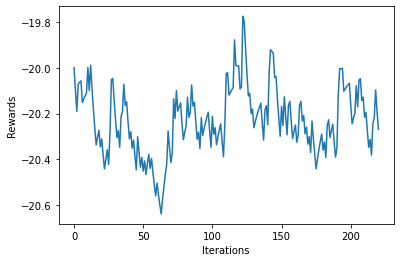

In [ ]:
### Training Pong ###
with tf.device('/GPU:0'):

  # Hyperparameters
  learning_rate=1e-4
  MAX_ITERS = 10000 # increase the maximum number of episodes, since Pong is more complex!

  # Model and optimizer
  pong_model = create_pong_model()
  optimizer = tf.keras.optimizers.Adam(learning_rate)

  # plotting
  smoothed_reward = mdl.util.LossHistory(smoothing_factor=0.9)
  plotter = mdl.util.PeriodicPlotter(sec=5, xlabel='Iterations', ylabel='Rewards')
  memory = Memory()

  for i_episode in range(MAX_ITERS):

    plotter.plot(smoothed_reward.get())

    # Restart the environment
    observation = env.reset()
    previous_frame = mdl.lab3.preprocess_pong(observation)

    while True:
        # Pre-process image 
        current_frame = mdl.lab3.preprocess_pong(observation)
        
        '''TODO: determine the observation change
        Hint: this is the difference between the past two frames'''
        obs_change = current_frame - previous_frame
        
        '''TODO: choose an action for the pong model, using the frame difference, and evaluate'''
        action = choose_action(pong_model, obs_change)
        # Take the chosen action
        next_observation, reward, done, info = env.step(action)

        '''TODO: save the observed frame difference, the action that was taken, and the resulting reward!'''
        memory.add_to_memory(obs_change, action, reward)
        
        # is the episode over? did you crash or do so well that you're done?
        if done:
            # determine total reward and keep a record of this
            total_reward = sum(memory.rewards)
            smoothed_reward.append( total_reward )

            # begin training
            train_step(pong_model, 
                      optimizer, 
                      observations = np.stack(memory.observations, 0), 
                      actions = np.array(memory.actions),
                      discounted_rewards = discount_rewards(memory.rewards))
            
            memory.clear()
            break

        observation = next_observation
        previous_frame = current_frame

Finally we can put our trained agent to the test! It will play in a newly instantiated Pong environment against the "computer", a base AI system for Pong. Your agent plays as the green paddle. Let's watch the match instant replay!

In [ ]:
saved_pong = mdl.lab3.save_video_of_model(
    pong_model, "Pong-v0", obs_diff=True, 
    pp_fn=mdl.lab3.preprocess_pong)
mdl.lab3.play_video(saved_pong)

## 3.10 Conclusion

That's it! Congratulations on training two RL agents and putting them to the test! We encourage you to consider the following:

*   How does the agent perform?
*   Could you train it for shorter amounts of time  and still perform well?
*   Do you think that training longer would help even more? 
* How does the complexity of Pong relative to Cartpole alter the rate at which the agent learns and its performance? 
* What are some things you could change about the agent or the learning process to potentially improve performance?

If you want to go further, try to optimize your model to achieve the best performance! **[Email us](mailto:introtodeeplearning-staff@mit.edu) a copy of your notebook with the Pong training executed AND a saved video of your Pong agent competing! We'll give out prizes to the best performers!**